# CS5814: Assignment 2

## Problem 1

### Imports and config

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Supressing Jupyter Notebook torchvision installation error 

import torch
from torchvision import transforms, datasets
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pandas as pd

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [2]:
# Setting random seeds
RANDOM_SEED = 3819969
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [3]:
# Confirming GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Network Definitions

### RNN

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, hiden_layer_width, num_layers, num_classes):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hiden_layer_width = hiden_layer_width
        self.num_layers = num_layers
        self.num_classes = num_classes
        
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hiden_layer_width,
                          num_layers=num_layers,
                          batch_first=True)
        
        # Based only on the final hidden layer output
        self.fc = nn.Linear(hiden_layer_width, num_classes)  
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Defining the forawrd pass
        
        # Zero vector input for first hidden layer
        h0 = torch.zeros(self.num_layers, x.size(0), self.hiden_layer_width).to(device)
        
        output, hidden_final = self.rnn(x, h0)
        
        # size = [Batch, Seq length, hidden size]
        output = output[:, -1, :]
        output = self.fc(output)
        output = self.softmax(output)
        
        return output

### LSTM

In [5]:
class LSTM(nn.Module):
    def __init__(self, input_size, hiden_layer_width, num_layers, num_classes):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hiden_layer_width = hiden_layer_width
        self.num_layers = num_layers
        self.num_classes = num_classes
        
        self.lstm = nn.LSTM(input_size=input_size,
                          hidden_size=hiden_layer_width,
                          num_layers=num_layers,
                          batch_first=True)
        
        # Based only on the final hidden layer output
        self.fc = nn.Linear(hiden_layer_width, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Defining the forawrd pass
        
        # Zero vector input for inital c0 h0
        h0 = torch.zeros(self.num_layers, x.size(0), self.hiden_layer_width).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hiden_layer_width).to(device)

        output, hidden_final = self.lstm(x, (h0, c0))
            
        # size = [Batch, Seq length, hidden size]
        output = output[:, -1, :]        
        output = self.fc(output)
        output = self.softmax(output)
        
        return output

## Loading and preprocessing data

In [6]:
# Loading data

test = pd.read_csv('SentimentAnalysisDataset/test.csv', header=None).to_numpy()
train = pd.read_csv('SentimentAnalysisDataset/train.csv', header=None).to_numpy()
word_vectors = pd.read_csv('SentimentAnalysisDataset/word-vectors.txt',keep_default_na=False, header=None)
word_vectors = word_vectors.astype({0: str}).to_numpy()

In [7]:
# Consturcting word to vector dictionary from word-vectors.txt

word_to_vector = dict(zip(word_vectors[:,0],np.array(word_vectors[:,1:]).tolist()))

In [8]:
# Checking that edge case words are processed correctly with the above numpy methods (Previously were processed incorrectly)

print(word_to_vector['nan'])
print(word_to_vector['null'])

[-0.39977, 0.66003, -0.029123, 1.9762, 0.41529, -0.70645, 0.25503, -0.45353, -0.051584, -0.4322, 0.070135, 0.57032, 0.13173, -0.70849, -0.11273, 0.020869, -0.25649, 0.078269, 0.44942, 1.3969, -0.27041, -0.0321, 1.0279, -0.60691, 0.58401, -0.6119, 0.039204, -0.070191, -1.322, -1.1289, 0.73278, 0.32938, 0.79808, 1.1177, -0.62425, -0.24516, -0.66017, 0.35718, 0.32817, 0.20522, 0.31787, 0.19557, -0.10514, -0.22896, 0.26091, -1.1798, -0.44656, -0.27054, 0.73332, -0.20141]
[0.72264, -0.27793, 0.65742, 0.78844, 0.83099, 1.6508, 0.54629, -0.46256, -0.32629, 0.29796, 0.70848, 0.35735, -0.016883, 0.59087, 0.41297, 0.75961, 0.41958, -0.93936, -0.30306, -0.27569, -0.60469, -0.8049, 0.32672, 0.37067, 0.57548, 0.33838, -0.034498, 0.55479, 0.71674, -0.29584, 0.1224, -0.88839, -1.1049, -0.71087, -0.27688, -1.0001, 1.5323, -0.37203, -0.61428, 0.43449, 0.54015, -0.31854, -0.26729, 0.51813, -2.0541, 0.42732, -0.095361, 0.59952, 0.83795, -0.17677]


In [9]:
def sentace_to_vector(sentance):
    # Helper function to process a given sentance into a vectorized words, padded/truncated to length of 95.
    
    split_sentace = sentance.split(" ")
    empty_word = [0] * 50
    word_vectors = [empty_word] * 95
    
    for i, word in enumerate(split_sentace):
        if i == 95:
            break
        word_vectors[i] = (word_to_vector[word])
        
    return word_vectors

In [10]:
def preprocess_data(dataset):
    # Helper function to preprocess entire dataset
    # Returns data_tensor and label_tensor of vectorized words
    # Note that positive is encoded as [0.0,1.0]

    data_vectors = []
    
    for sentance in dataset[:, 1]:
        data_vectors.append(sentace_to_vector(sentance))

    label_ints = []
    for label in dataset[:, 0]:
        if label == "postive":
            label_ints.append([0.0,1.0])

        elif label == "negative":
            label_ints.append([1.0,0.0])

    data_tensor = torch.FloatTensor(data_vectors)
    label_tensor = torch.FloatTensor(label_ints)
    
    return data_tensor, label_tensor

In [11]:
# Generating train and test data

train_data, train_labels = preprocess_data(train)
test_data, test_labels = preprocess_data(test)

In [12]:
# Checking the length of train and test data

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

torch.Size([20000, 95, 50]) torch.Size([20000, 2])
torch.Size([5000, 95, 50]) torch.Size([5000, 2])


In [13]:
def accuracy_calculator(prediction, truth):
    # Helper fucntion to calculate components used in envaluation metrics

    labels = torch.argmax(truth, dim=1)
    predictions = torch.argmax(prediction, dim=1)
    
    positive_ids = (labels == 1).nonzero(as_tuple=True)
    negative_ids = (labels == 0).nonzero(as_tuple=True)

    TP = (predictions[positive_ids] == 1.).sum(dim=0).item()
    TN = (predictions[negative_ids] == 0.).sum(dim=0).item()
    FP = (predictions[positive_ids] == 0.).sum(dim=0).item()
    FN = (predictions[negative_ids] == 1.).sum(dim=0).item()
    total = prediction.shape[0]
    
    return(TP, TN, FP, FN, total)

In [14]:
def metric_calculator(TP, TN, FP, FN, total):
    # Helper fucntion to calculate evaluation metrics
    # Note that these are manually defined, yet could use inbult libs (as done in Problem 2)
    
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    F1 = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) != 0 else 0
    accuracy = (TP + TN) / total if total != 0 else 0

    return(precision, recall, accuracy, F1)

## Training and output plots

### RNN Training

In [15]:
# RNN Hyperparams

# Network
input_size = 50
max_sequence_len = 95
hiden_layer_width = 128  # m in assignment (m=128)
num_layers = 1
num_classes = 2

# Learning
batch_size = 32
learning_rate = 0.00001
epoch_max = 30

In [16]:
# Load RNN model
model = RNN(input_size, hiden_layer_width, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Tracking arrays
metric_list_RNN = []
loss_array_RNN = []
val_loss_array_RNN = []

# Train the model
mini_batch_counter = 0

for epoch in range(epoch_max+1):
    
    # randomize index orders for each epoch
    idx = np.random.choice(np.arange(train_data.shape[0]), train_data.shape[0], replace=False)

    for mini_batch_id, i in enumerate(range(0, train_data.shape[0], batch_size)):
        
        # Extract given words and labels based on shuffle ids
        words = train_data[idx[i:i + batch_size]].to(device)
        labels = train_labels[idx[i:i + batch_size]].to(device)
        
        # Forward pass
        output = model(words)
        loss = criterion(output, labels)
        loss_array_RNN.append(loss.item())
        mini_batch_counter += 1
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Validation step (end of epoch)
    model.eval()
    val_accuracy_minibatch_list = []
    val_loss_array_local = []

    for val_batch_id, j in enumerate(range(0, test_data.shape[0], batch_size)):

        # Creating mini batch for evaluation
        val_words = test_data[j:j + batch_size].to(device)
        val_labels = test_labels[j:j + batch_size].to(device)

        # Evaluating
        val_output = model(val_words)
        val_loss = criterion(val_output, val_labels)
        val_loss_array_local.append(val_loss.item())

        # Calculating evaluation metrics prelims
        TP, TN, FP, FN, total = accuracy_calculator(val_output, val_labels)
        val_accuracy_minibatch_list.append([TP, TN, FP, FN, total])

    # Collating TP, TN, FP, FN over all minibatches
    TP, TN, FP, FN, total = np.sum(np.array(val_accuracy_minibatch_list), 0)
    val_loss_array_RNN.append(np.average(val_loss_array_local))
    
    # Calculating performance metrics
    precision, recall, accuracy, F1 = metric_calculator(TP, TN, FP, FN, total)
    metric_list_RNN.append([precision, recall, accuracy, F1])
    
    model.train()

    # Outputting validation results
    print(("Epoch: {}, Loss: {:.3f}, Val_Loss: {:.3f}, Val_acc: {:.3f}, "
           "Val_precision: {:.3f}, Val_recall: {:.3f}, Val_F1: {:.3f}").format(epoch,
                                                                   loss.item(),val_loss_array_RNN[-1],
                                                                   accuracy, precision, recall, F1))

Epoch: 0, Loss: 0.710, Val_Loss: 0.694, Val_acc: 0.499, Val_precision: 0.448, Val_recall: 0.499, Val_F1: 0.472
Epoch: 1, Loss: 0.695, Val_Loss: 0.693, Val_acc: 0.510, Val_precision: 0.376, Val_recall: 0.514, Val_F1: 0.434
Epoch: 2, Loss: 0.693, Val_Loss: 0.692, Val_acc: 0.519, Val_precision: 0.437, Val_recall: 0.522, Val_F1: 0.476
Epoch: 3, Loss: 0.689, Val_Loss: 0.691, Val_acc: 0.526, Val_precision: 0.465, Val_recall: 0.529, Val_F1: 0.495
Epoch: 4, Loss: 0.680, Val_Loss: 0.690, Val_acc: 0.543, Val_precision: 0.498, Val_recall: 0.547, Val_F1: 0.522
Epoch: 5, Loss: 0.673, Val_Loss: 0.684, Val_acc: 0.569, Val_precision: 0.586, Val_recall: 0.566, Val_F1: 0.576
Epoch: 6, Loss: 0.651, Val_Loss: 0.643, Val_acc: 0.654, Val_precision: 0.658, Val_recall: 0.652, Val_F1: 0.655
Epoch: 7, Loss: 0.616, Val_Loss: 0.638, Val_acc: 0.657, Val_precision: 0.648, Val_recall: 0.660, Val_F1: 0.654
Epoch: 8, Loss: 0.673, Val_Loss: 0.635, Val_acc: 0.657, Val_precision: 0.612, Val_recall: 0.672, Val_F1: 0.641
E

### RNN Outputs

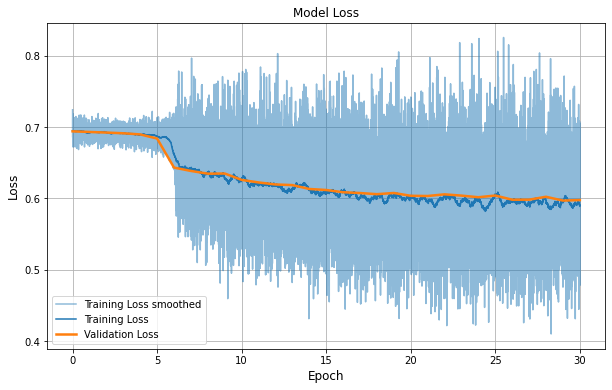

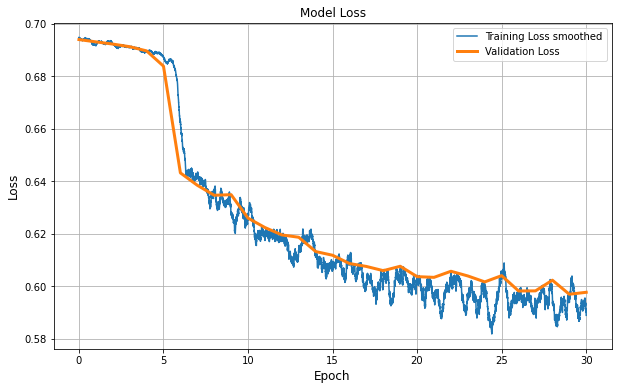

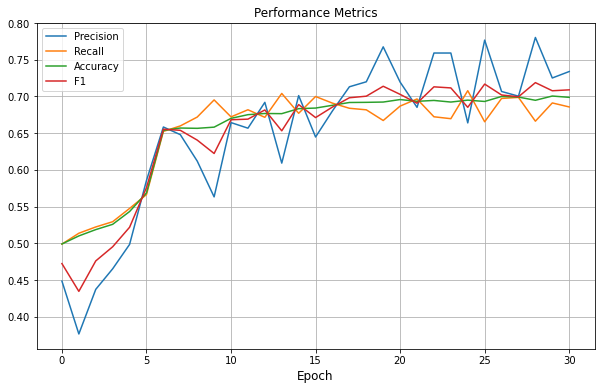

In [28]:
loss_avg_RNN = np.convolve(loss_array_RNN, np.ones(200)/200, mode='valid')
train_len = train_data.shape[0]

fig = plt.figure()
plt.plot(np.linspace(0, 30, len(loss_array_RNN)), loss_array_RNN, label='Training Loss smoothed', color='tab:blue', alpha=0.5)
plt.plot(np.linspace(0, 30, len(loss_avg_RNN)), loss_avg_RNN, label='Training Loss', color='tab:blue')
plt.plot(np.linspace(0, 30, len(val_loss_array_RNN)), val_loss_array_RNN, label='Validation Loss', color='tab:orange', linewidth=2.5)

plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
fig.set_size_inches(10, 6)
plt.title('Model Loss')
plt.legend()
plt.grid()
plt.show()


fig = plt.figure()
plt.plot(np.linspace(0, 30, len(loss_avg_RNN)), loss_avg_RNN, label='Training Loss smoothed', color='tab:blue')
plt.plot(np.linspace(0, 30, len(val_loss_array_RNN)), val_loss_array_RNN, label='Validation Loss', color='tab:orange', linewidth=3)
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
fig.set_size_inches(10, 6)
plt.title('Model Loss')
plt.legend()
plt.grid()
plt.show()


fig = plt.figure()
fig.set_size_inches(10, 6)
metrics_RNN = np.array(metric_list_RNN)
plt.plot(metrics_RNN[:,0], label='Precision')
plt.plot(metrics_RNN[:,1], label='Recall')
plt.plot(metrics_RNN[:,2], label='Accuracy')
plt.plot(metrics_RNN[:,3], label='F1')
plt.xlabel('Epoch', fontsize = 12)
plt.title('Performance Metrics')
plt.legend()
plt.grid()
plt.show()

In [18]:
print("Final Performance Metrics")
print("-------------------------")
for i, metric in enumerate(['Precision', 'Recall', 'Accuracy', 'F1']):
    print("{0}: {1:.4f}".format(metric, metrics_RNN[-1,i]))
print("-------------------------")


Final Performance Metrics
-------------------------
Precision: 0.7340
Recall: 0.6857
Accuracy: 0.6988
F1: 0.7090
-------------------------


### LSTM Training

In [19]:
# LSTM Hyperparams 

# Network
input_size = 50
max_sequence_len = 95
hiden_layer_width = 128  # m in assignment (m=128)
num_layers = 1
num_classes = 2

# Learning
batch_size = 32
learning_rate = 0.0001
epoch_max = 30

In [20]:
# Load LSTM model
model = LSTM(input_size, hiden_layer_width, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Tracking arrays
loss_array_LSTM = []
metric_list_LSTM = []
val_loss_array_LSTM = []

# Train the model

for epoch in range(epoch_max+1):
    
    # randomize index orders for each epoch
    idx = np.random.choice(np.arange(train_data.shape[0]), train_data.shape[0], replace=False)

    for mini_batch_id, i in enumerate(range(0, train_data.shape[0], batch_size)):

        # Extract given words and labels based on shuffle ids
        words = train_data[idx[i:i + batch_size]].to(device)
        labels = train_labels[idx[i:i + batch_size]].to(device)
        
        # Forward pass
        output = model(words)
        loss = criterion(output, labels)
        loss_array_LSTM.append(loss.item())
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Validation (end of epoch)
    model.eval()
    val_accuracy_minibatch_list = []
    val_loss_local = []
    for val_batch_id, j in enumerate(range(0, test_data.shape[0], batch_size)):
        
        # Creating mini batch for evaluation
        val_words = test_data[j:j + batch_size].to(device)
        val_labels = test_labels[j:j + batch_size].to(device)

        # Evaluating
        val_output = model(val_words)
        val_loss = criterion(val_output, val_labels)
        val_loss_local.append(val_loss.item())
        
        # Calculating evaluation metrics prelims
        TP, TN, FP, FN, total = accuracy_calculator(val_output, val_labels)
        val_accuracy_minibatch_list.append([TP, TN, FP, FN, total])

    # Collating TP, TN, FP, FN over all minibatches
    TP, TN, FP, FN, total = np.sum(np.array(val_accuracy_minibatch_list), 0)
    
    # Calculating performance metrics
    precision, recall, accuracy, F1 = metric_calculator(TP, TN, FP, FN, total)
    metric_list_LSTM.append([precision, recall, accuracy, F1])
    val_loss_array_LSTM.append(np.average(val_loss_local))
    model.train()

    # Outputting validation results
    print(("Epoch: {}, Loss: {:.3f}, Val_Loss: {:.3f}, Val_acc: {:.3f}, "
           "Val_precision: {:.3f}, Val_recall: {:.3f}, Val_F1: {:.3f}").format(epoch,
                                                                   loss.item(),val_loss_array_LSTM[-1],
                                                                   accuracy, precision, recall, F1))


Epoch: 0, Loss: 0.620, Val_Loss: 0.638, Val_acc: 0.651, Val_precision: 0.794, Val_recall: 0.617, Val_F1: 0.695
Epoch: 1, Loss: 0.630, Val_Loss: 0.612, Val_acc: 0.688, Val_precision: 0.715, Val_recall: 0.678, Val_F1: 0.696
Epoch: 2, Loss: 0.647, Val_Loss: 0.585, Val_acc: 0.714, Val_precision: 0.739, Val_recall: 0.703, Val_F1: 0.721
Epoch: 3, Loss: 0.597, Val_Loss: 0.574, Val_acc: 0.718, Val_precision: 0.751, Val_recall: 0.704, Val_F1: 0.727
Epoch: 4, Loss: 0.563, Val_Loss: 0.569, Val_acc: 0.724, Val_precision: 0.673, Val_recall: 0.750, Val_F1: 0.710
Epoch: 5, Loss: 0.572, Val_Loss: 0.564, Val_acc: 0.732, Val_precision: 0.780, Val_recall: 0.711, Val_F1: 0.744
Epoch: 6, Loss: 0.574, Val_Loss: 0.565, Val_acc: 0.728, Val_precision: 0.828, Val_recall: 0.690, Val_F1: 0.753
Epoch: 7, Loss: 0.542, Val_Loss: 0.557, Val_acc: 0.739, Val_precision: 0.791, Val_recall: 0.717, Val_F1: 0.752
Epoch: 8, Loss: 0.536, Val_Loss: 0.562, Val_acc: 0.738, Val_precision: 0.626, Val_recall: 0.807, Val_F1: 0.705
E

### LSTM Outputs

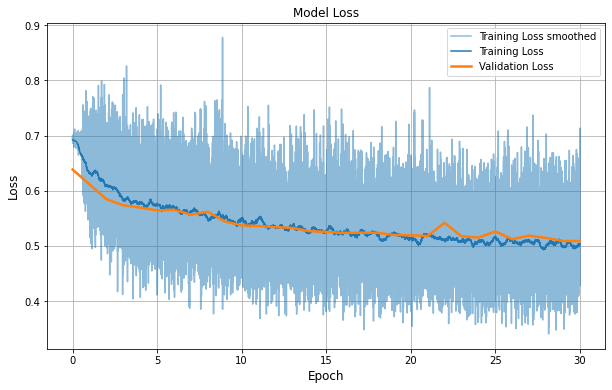

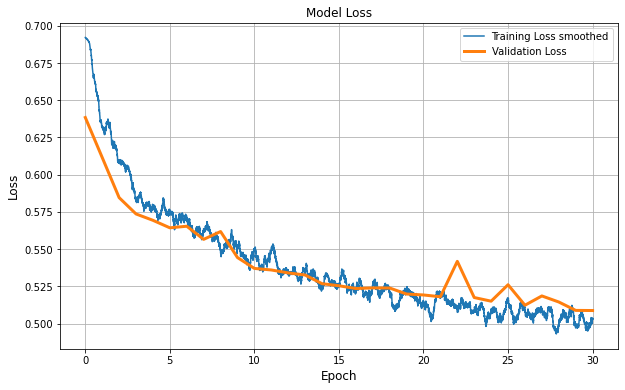

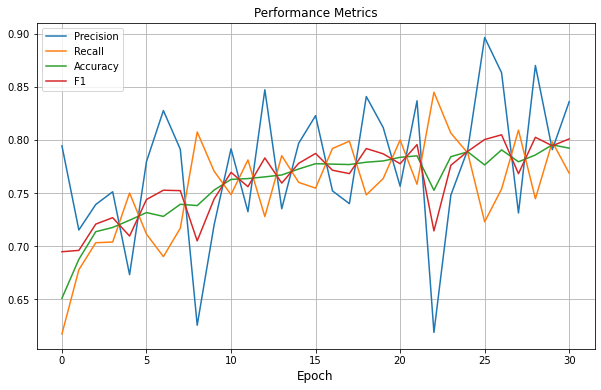

In [25]:
loss_avg_LSTM = np.convolve(loss_array_LSTM, np.ones(200)/200, mode='valid')
train_len = train_data.shape[0]

fig = plt.figure()
fig.set_size_inches(10, 6)
plt.plot(np.linspace(0, 30, len(loss_array_LSTM)), loss_array_LSTM, label='Training Loss smoothed',color='tab:blue', alpha=0.5)
plt.plot(np.linspace(0, 30, len(loss_avg_LSTM)), loss_avg_LSTM, label='Training Loss',color='tab:blue')
plt.plot(np.linspace(0, 30, len(val_loss_array_LSTM)), val_loss_array_LSTM, label='Validation Loss',color='tab:orange',linewidth=2.5)
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.title('Model Loss')
plt.legend()
plt.grid()
plt.show()

         
fig = plt.figure()
fig.set_size_inches(10, 6)
plt.plot(np.linspace(0, 30, len(loss_avg_LSTM)), loss_avg_LSTM, label='Training Loss smoothed',color='tab:blue')
plt.plot(np.linspace(0, 30, len(val_loss_array_LSTM)), val_loss_array_LSTM, label='Validation Loss',color='tab:orange',linewidth=3)
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.title('Model Loss')
plt.legend()
plt.grid()
plt.show()         

fig = plt.figure()
fig.set_size_inches(10, 6)
metrics_LSTM = np.array(metric_list_LSTM)
plt.plot(metrics_LSTM[:,0], label='Precision')
plt.plot(metrics_LSTM[:,1], label='Recall')
plt.plot(metrics_LSTM[:,2], label='Accuracy')
plt.plot(metrics_LSTM[:,3], label='F1')
plt.xlabel('Epoch', fontsize = 12)
plt.title('Performance Metrics')
plt.legend()
plt.grid()
plt.show()

In [22]:
print("Final Performance Metrics")
print("-------------------------")
for i, metric in enumerate(['Precision', 'Recall', 'Accuracy', 'F1']):
    print("{0}: {1:.4f}".format(metric, metrics_LSTM[-1,i]))
print("-------------------------")

Final Performance Metrics
-------------------------
Precision: 0.8360
Recall: 0.7687
Accuracy: 0.7922
F1: 0.8009
-------------------------


## Comparison plots

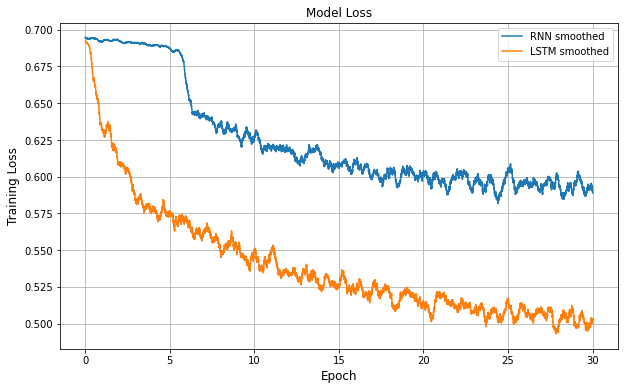

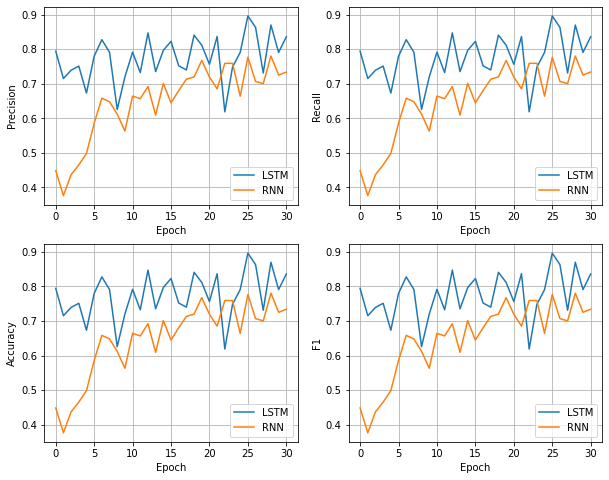

In [27]:
fig = plt.figure()
fig.set_size_inches(10, 6)
plt.plot(np.linspace(0, 30, len(loss_avg_RNN)), loss_avg_RNN, label='RNN smoothed')
plt.plot(np.linspace(0, 30, len(loss_avg_LSTM)), loss_avg_LSTM, label='LSTM smoothed')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Training Loss', fontsize = 12)
plt.title('Model Loss')
plt.legend()
plt.grid()
plt.show()


fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 8)


metric_types = ['Precision', 'Recall', 'Accuracy', 'F1']
for i, ax in enumerate(axes.flatten()):
    metric = metric_types[i]
    ax.plot(metrics_LSTM[:,0], label='LSTM'.format(metric))
    ax.plot(metrics_RNN[:,0], label='RNN'.format(metric))
    ax.set_ylabel('{}'.format(metric))  # NOTE TYPO here throughout :(
    ax.set_xlabel('Epoch')
    ax.grid()
    ax.legend()

plt.show()